In [1]:
%%capture
!pip install -r requirements.txt

In [2]:
%matplotlib inline

In [3]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import patchworklib as pw

from py_helper_functions import *

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

from stargazer import stargazer

In [4]:
citizenship_dict = {
    "Native, Born In US": 1,
    "Foreign Born, Not a US Citizen": 2,
    "Foreign Born, US Cit By Naturalization": 3,
    "Native, Born Abroad Of US Parent(s)": 4,
    "Native, Born in PR or US Outlying Area": 5
}
class_dict = {
    "Private, For Profit": 1,
    "Private, Nonprofit": 2,
    "Government - Federal": 3,
    "Government - State": 4,
    "Government - Local": 5
}

def get_cleaned_data(src: str) -> pd.DataFrame:
    '''
    This function takes a path to a csv file, cleans it and returns the cleaned dataframe
    :param src: path to file
    :return: dataframe with cleaned data
    '''
    df = pd.read_csv(src)
    
    # Filter the data for: 
    #   occ2012 between 7700 and 8965 (Tech occupations), 
    #   high school graduate and above,
    #   work week > 0, 
    #   work minimum 20hrs per week, 
    #   hourly wage >= 1
    comp_sample = df[(df['occ2012'] >= 1005)
                     & (df['occ2012'] <= 1107)
                     & (df['grade92'] >= 39) 
                     & (df['uhours'] >= 20) 
                     & (df['earnwke'] > 0)
                     & (df['earnwke']/df['uhours'] >= 1)].iloc[:, 1:]
    
    #drop the raw df
    del df
    
    # Add a column 'hourly_wage' to the DataFrame
    comp_sample['hourly_wage'] = (comp_sample['earnwke'] / comp_sample['uhours']).round(decimals=2)
    # add column female to have boolean for male or female
    comp_sample['female'] = comp_sample['sex'].apply(lambda x: 1 if x == 2 else 0)
    # add column for age squared
    comp_sample['agesq'] = np.power(comp_sample['age'], 2)
    # add column for citizen to have boolean value if worker has US citizenship
    comp_sample['citizenship_status_code'] = comp_sample['prcitshp'].apply(lambda x: citizenship_dict[x])
    # add column for occupation class code
    comp_sample['class_code'] = comp_sample['class'].apply(lambda x: class_dict[x])
    
    # create dummy variables
    comp_sample = pd.get_dummies(columns=['citizenship_status_code', 'marital', 'grade92', 'class_code'], data=comp_sample, prefix=['citizen', 'marital', 'edu', 'class'], drop_first=True, dtype=int)
    
    # round to 2 decimal places
    comp_sample = comp_sample.round(decimals=2)
    
    return comp_sample

In [5]:
# cleaned_df = get_cleaned_data('https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment1/morg-2014-emp.csv')
cleaned_df = get_cleaned_data('morg-2014-emp.csv')
cleaned_df.head()

,hhid,intmonth,stfips,weight,earnwke,uhours,race,ethnic,age,sex,...,edu_41,edu_42,edu_43,edu_44,edu_45,edu_46,class_2,class_3,class_4,class_5
16,731019430119001,January,AL,2992.10,1538.46,40,2,NaN,53,2,...,0,0,1,0,0,0,0,0,0,0
155,673032906039520,January,AK,411.56,1346.15,40,3,NaN,47,2,...,0,0,0,0,0,0,0,0,0,1
293,207004430306994,January,AZ,3410.89,2500.00,40,4,NaN,51,1,...,0,0,0,1,0,0,0,0,0,0
296,236096309400800,January,AZ,3916.33,2500.00,40,4,NaN,47,1,...,0,0,1,0,0,0,0,0,0,0
324,914299270769003,January,AZ,5115.47,1250.00,45,1,NaN,37,1,...,0,0,1,0,0,0,0,0,0,0


In [6]:
# get the data set summary statistics
stats = cleaned_df[['earnwke', 'uhours', 'hourly_wage']].describe().T
stats['mode'] = cleaned_df[['earnwke', 'uhours', 'hourly_wage']].mode().squeeze()
stats.T

,earnwke,uhours,hourly_wage
count,4304.000000,4304.000000,4304.000000
mean,1437.250207,41.504414,34.580764
std,667.475294,5.638129,15.639146
min,92.300000,20.000000,2.310000
25%,923.000000,40.000000,22.500000
50%,1346.150000,40.000000,32.210000
75%,1923.000000,40.000000,45.000000
max,2884.610000,80.000000,120.190000
mode,2884.610000,40.000000,48.080000


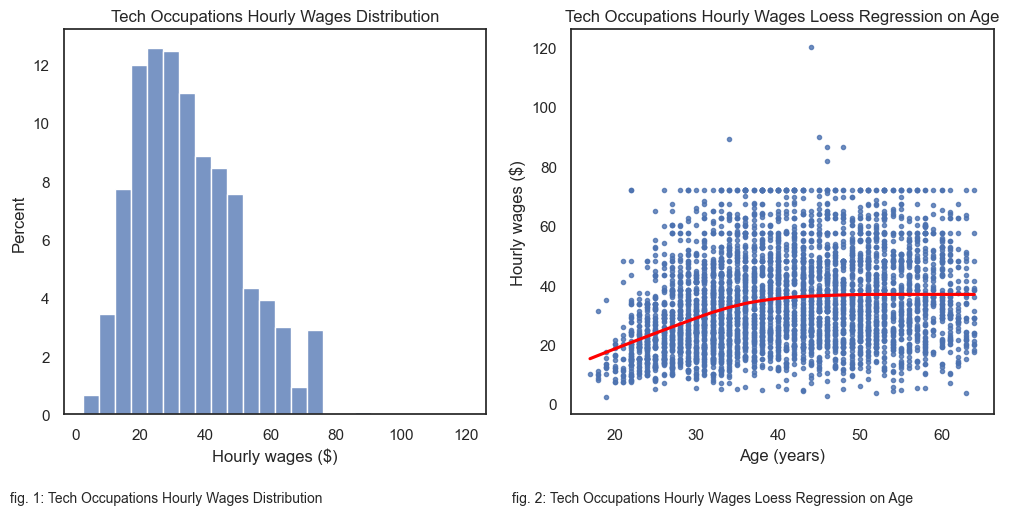

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
sns.set(style="white")
fig1 = (sns.histplot(
    data = cleaned_df,
    x = 'hourly_wage', stat='percent', binwidth=5, ax=ax1))
fig1.set(title='Tech Occupations Hourly Wages Distribution', xlabel="Hourly wages ($)", ylabel="Percent")
ax1.text(-20, -3, 'fig. 1: Tech Occupations Hourly Wages Distribution', size=10)
fig2 = (sns.regplot(
    data = cleaned_df,
    x = 'age', y = 'hourly_wage', 
    marker= '.',
    fit_reg= True, lowess= True, line_kws={"color": "red"}, ax=ax2))
fig2.set(title='Tech Occupations Hourly Wages Loess Regression on Age', xlabel='Age (years)', ylabel='Hourly wages ($)')
ax2.text(7.5, -33, 'fig. 2: Tech Occupations Hourly Wages Loess Regression on Age', size=10)
fig.show()

In [8]:
### Cross validate OLS with combining sklearn k-fold cross validation and statsmodels ols formula
def cv_reg(formula, data, kfold, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []

    # Calculating OLS for each fold

    for train_index, test_index in kfold.split(data):
        # print("TRAIN:", train_index, "TEST:", test_index)
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]
        rmse_list += [rmse(data_train[formula.split("~")[0]], model.predict(data_train))]
        rmse_list_test += [rmse(data_test[formula.split("~")[0]], model.predict(data_test))]
    nvars = model.df_model

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }

def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cv_list))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [9]:
# regression formulas
reg_formulas = ["hourly_wage~age+agesq",
                "hourly_wage~age+agesq+female+ownchild",
                "hourly_wage~age+agesq+female+ownchild+" + '+'.join([col for col in cleaned_df.columns if 'class_' in col])
                + '+' + '+'.join([col for col in cleaned_df.columns if 'edu_' in col]),
                "hourly_wage~age+agesq+female+ownchild+" + '+'.join([col for col in cleaned_df.columns if 'class_' in col]) 
                + '+' + '+'.join([col for col in cleaned_df.columns if 'edu_' in col])
                + '+' + '+'.join([col for col in cleaned_df.columns if 'marital_' in col])
                + '+' + '+'.join([col for col in cleaned_df.columns if 'citizen_' in col])]
reg_formulas;

In [10]:
k = KFold(n_splits=5, shuffle=False, random_state=None)

# create 4 cross validations
cv1 = cv_reg(reg_formulas[0], cleaned_df, k, "HC1")
cv2 = cv_reg(reg_formulas[1], cleaned_df, k, "HC1")
cv3 = cv_reg(reg_formulas[2], cleaned_df, k, "HC1")
cv4 = cv_reg(reg_formulas[3], cleaned_df, k, "HC1")

cv_list = [cv1, cv2, cv3, cv4]

cv_summary = summarize_cv(cv_list).round(decimals=3)
cv_summary

,Model1,Model2,Model3,Model4
Fold1,14.903,14.690,13.825,13.779
Fold2,14.979,14.760,13.777,13.712
Fold3,14.904,14.674,13.795,13.745
Fold4,14.759,14.577,13.667,13.596
Fold5,14.783,14.531,13.694,13.656
Average,14.865,14.646,13.752,13.697


In [11]:
# create the regression models
reg1 = smf.ols(formula=reg_formulas[0], data=cleaned_df).fit(cov_type="HC1")
reg2 = smf.ols(formula=reg_formulas[1], data=cleaned_df).fit(cov_type="HC1")
reg3 = smf.ols(formula=reg_formulas[2], data=cleaned_df).fit(cov_type="HC1")
reg4 = smf.ols(formula=reg_formulas[3], data=cleaned_df).fit(cov_type="HC1")

reg_list = [reg1, reg2, reg3, reg4]
bic = [round(x.bic, 2) for x in reg_list]
rmse_all = [round(rmse(cleaned_df[reg_formulas[x].split("~")[0]], reg_list[x].predict()), 3) for x in range(len(reg_list))]
rmse_kfold = (cv_summary.loc['Average']).tolist()
sg = stargazer.Stargazer(reg_list)
sg.add_line('BIC', bic, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg.add_line('RMSE', rmse_all, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg.add_line('CV RMSE', rmse_kfold, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg